<a href="https://colab.research.google.com/github/Bica-plus-equals/Environmental-Data-Analysis/blob/main/DGVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xarray netcdf4 dask matplotlib cartopy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xarray as xr
dgvm = xr.open_dataset('/content/drive/MyDrive/dgvm_monthly2.nc')
print(dgvm)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 492, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2020-12-01
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 6kB -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
Data variables:
    NEE      (time, lat, lon) float64 1GB ...


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


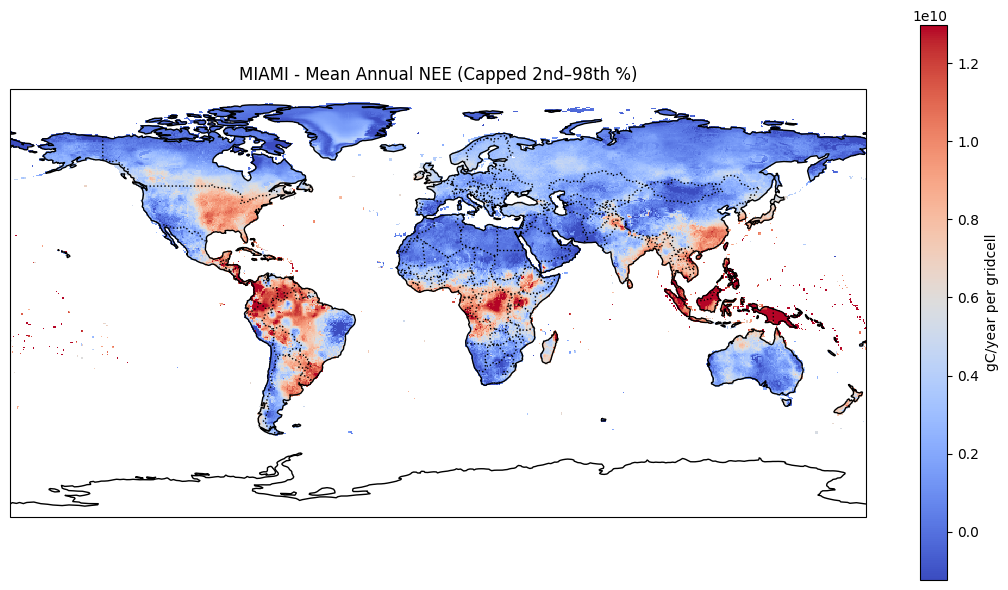

In [ ]:
#Not aggregated
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- 1. Compute mean annual NEE ---
nee_annual_mean = dgvm['NEE'].mean(dim='time')  # [lat, lon]

# --- 2. Compute area weights using cos(lat) ---
R = 6.371e6  # Earth radius in meters
dlat = np.deg2rad(0.5)   # assuming 0.5° grid
dlon = np.deg2rad(0.5)

lat_rad = np.deg2rad(dgvm['lat'].values)  # convert to numpy array
coslat = np.cos(lat_rad)  # [lat]

# area per gridcell in m²: area = R² * dlat * dlon * cos(lat)
area_per_lat = (R**2) * dlat * dlon * coslat  # [lat]
area_grid = np.outer(area_per_lat, np.ones(len(dgvm['lon'])))  # shape [lat, lon]

# --- 3. Multiply by area to get gC/year per gridcell ---
nee_total_gC = nee_annual_mean.values * area_grid  # gC/year

# # --- 4. Convert to PgC/year ---
# nee_total_PgC = nee_total_gC / 1e15  # PgC/year per gridcell
vmin, vmax = np.nanpercentile(nee_total_gC, [2, 98])

# --- 5. Plot ---
def plot_flux(data, title, vmin, vmax, cmap='coolwarm'):
    fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    c = ax.pcolormesh(
        dgvm['lon'], dgvm['lat'], data,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),
        shading='auto'
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(title)
    plt.colorbar(c, ax=ax, label='gC/year per gridcell')
    plt.tight_layout()
    plt.show()

plot_flux(nee_total_gC, 'MIAMI - Mean Annual NEE (Capped 2nd–98th %)', vmin, vmax)

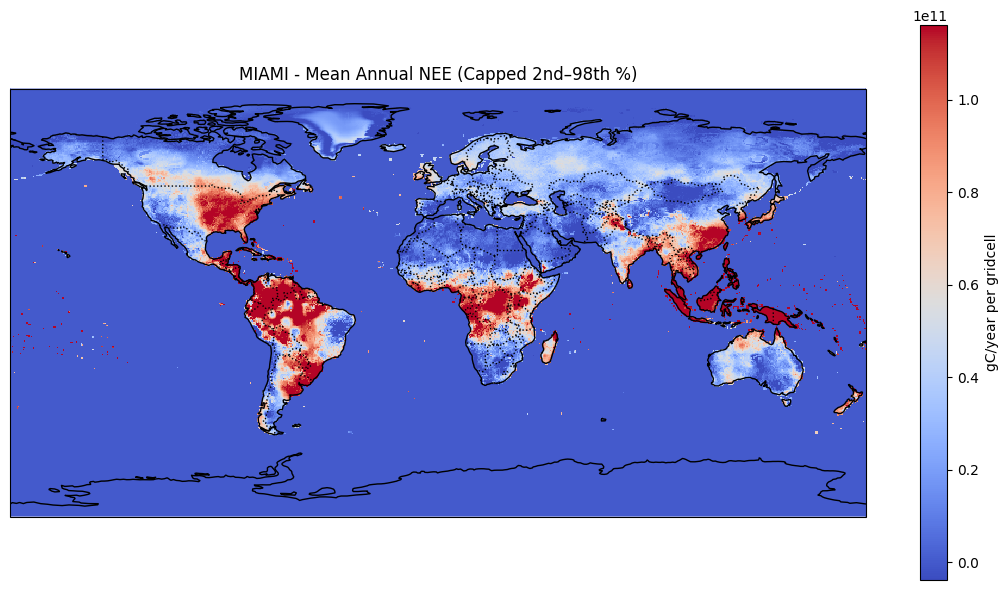

In [ ]:
#Annually agregated
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- 1. Aggregate monthly data to annual totals ---
# NEE is in gC/m²/month, so summing over months gives gC/m²/year
nee_annual = dgvm['NEE'].groupby('time.year').sum(dim='time')  # [year, lat, lon]
nee_annual_mean = nee_annual.mean(dim='year')  # [lat, lon]

# --- 2. Compute area weights using cos(lat) ---
R = 6.371e6  # Earth radius in meters
dlat = np.deg2rad(0.5)
dlon = np.deg2rad(0.5)

lat_rad = np.deg2rad(dgvm['lat'].values)
coslat = np.cos(lat_rad)
area_per_lat = (R**2) * dlat * dlon * coslat  # [lat]
area_grid = np.outer(area_per_lat, np.ones(len(dgvm['lon'])))  # [lat, lon]

# --- 3. Multiply by area to get total flux per gridcell (gC/year) ---
nee_total_gC = nee_annual_mean.values * area_grid  # [lat, lon], in gC/year

# --- 4. Cap values for visualization ---
vmin, vmax = np.nanpercentile(nee_total_gC, [2, 98])

# --- 5. Plotting ---
def plot_flux(data, title, vmin, vmax, cmap='coolwarm'):
    fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    c = ax.pcolormesh(
        dgvm['lon'], dgvm['lat'], data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        shading='auto'
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(title)
    plt.colorbar(c, ax=ax, label='gC/year per gridcell')
    plt.tight_layout()
    plt.show()

plot_flux(nee_total_gC, 'MIAMI - Mean Annual NEE (Capped 2nd–98th %)', vmin, vmax)


Timestamp: 2020-12-01T00:00:00.000000000


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


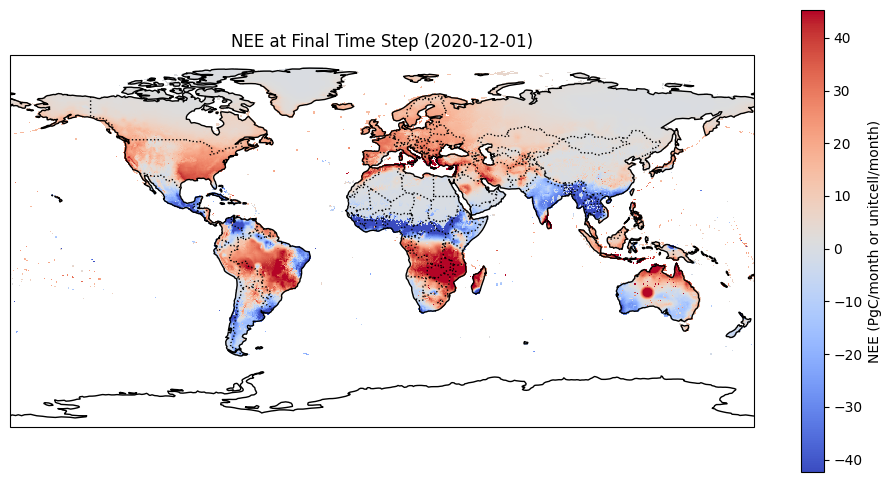

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load dataset
dgvm = xr.open_dataset('/content/drive/MyDrive/dgvm_monthly2.nc')

# Get coordinates
lat = dgvm['lat']
lon = dgvm['lon']

# Select NEE at the last time step
nee_last = dgvm['NEE'].isel(time=-1)  # -1 selects the last time point

# Optional: print timestamp to confirm
print("Timestamp:", str(dgvm['time'].isel(time=-1).values))

# Plotting function
def plot_flux(data, title, cmap='coolwarm', vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    c = ax.pcolormesh(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading='auto',
        vmin=vmin,
        vmax=vmax
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(title)
    plt.colorbar(c, ax=ax, label='NEE (PgC/month or unitcell/month)')
    plt.show()

# Clamp to 2nd–98th percentiles to avoid extreme outliers
# vmin = float(nee_last.quantile(0.02))
# vmax = float(nee_last.quantile(0.98))

# Plot
plot_flux(nee_last, 'NEE at Final Time Step (2020-12-01)', vmin=vmin, vmax=vmax)


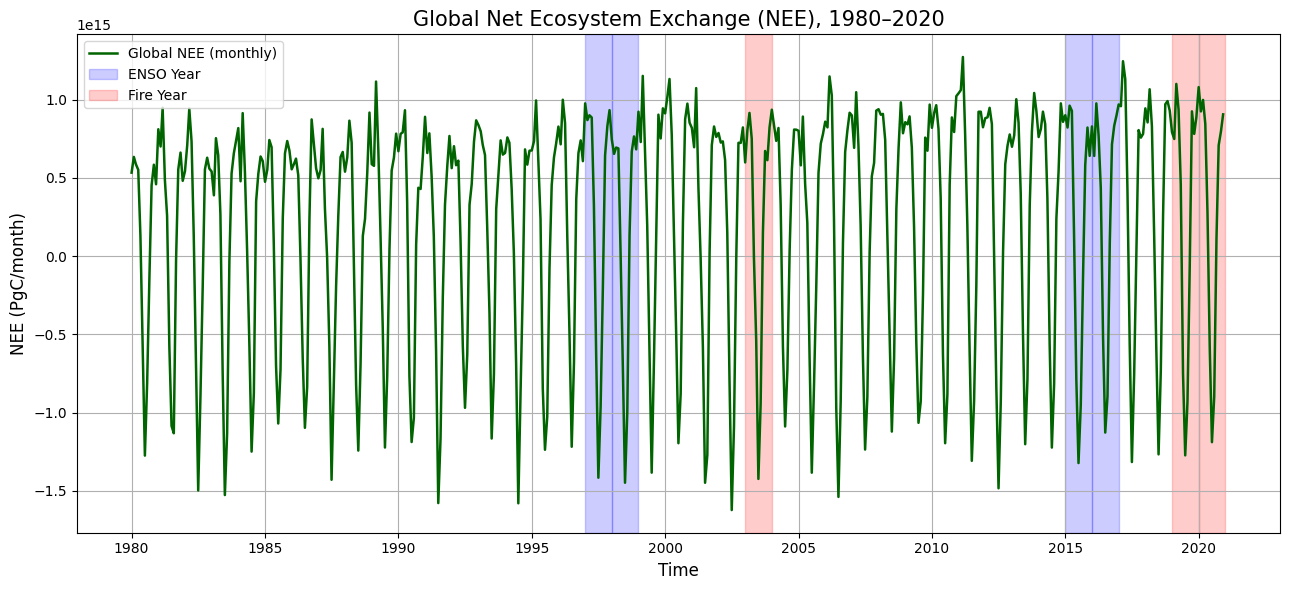

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

enso_years = [1997, 1998, 2015, 2016]  # strong ENSO years
fire_years = [2003, 2019, 2020]        # major fire years

# --- 1. Constants ---
R = 6.371e6  # Earth's radius in meters

# --- 2. Extract lat/lon and compute resolution ---
lat = dgvm['lat']
lon = dgvm['lon']
dlat = np.deg2rad(lat.diff('lat').mean().item())  # constant lat spacing in radians
dlon = np.deg2rad(lon.diff('lon').mean().item())  # constant lon spacing in radians

# --- 3. Compute area per grid cell ---
# Formula: area = R² * dlat * dlon * cos(lat)
lat_rad = np.deg2rad(lat)
area_per_lat = (R**2) * dlat * dlon * np.cos(lat_rad)

# Expand to full 2D array using broadcasting
area_2d = xr.DataArray(
    data=np.broadcast_to(area_per_lat.values[:, np.newaxis], (len(lat), len(lon))),
    coords={'lat': lat, 'lon': lon},
    dims=['lat', 'lon']
)
# --- 4. Global NEE (multiply by area and sum over lat/lon) ---
nee = dgvm['NEE']  # Units assumed to be kgC/m²/month
global_nee_month = (nee * area_2d).sum(dim=['lat', 'lon'])

# --- 6. Time variable ---
time = dgvm['time']

# --- 7. Plot ---
plt.figure(figsize=(13, 6))
plt.plot(time, global_nee_month, label='Global NEE (monthly)', color='darkgreen', linewidth=1.8)

# Highlight ENSO years with blue shading
for year in enso_years:
    start = np.datetime64(f'{year}-01-01')
    end = np.datetime64(f'{year}-12-31')
    plt.axvspan(start, end, color='blue', alpha=0.2,
                label='ENSO Year' if year == enso_years[0] else "")

# Highlight Fire years with red shading
for year in fire_years:
    start = np.datetime64(f'{year}-01-01')
    end = np.datetime64(f'{year}-12-31')
    plt.axvspan(start, end, color='red', alpha=0.2,
                label='Fire Year' if year == fire_years[0] else "")

plt.title('Global Net Ecosystem Exchange (NEE), 1980–2020', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('NEE (gC/month)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: "No variable named 'dxyp'. Variables on the dataset include ['time', 'lat', 'lon', 'NEE']"

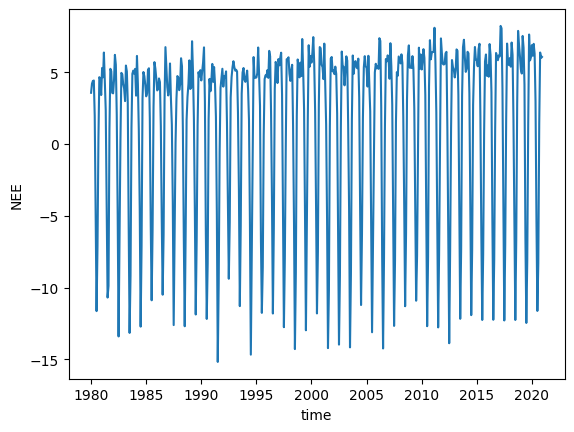

In [ ]:
dgvm.NEE.mean(dim=['lat', 'lon']).plot()

# Select flux variables
co2flux_land = dgvm['NEE']

# Grid cell area (assuming it's in m²)
area = dgvm['dxyp']

# Compute global fluxes by multiplying with area and summing over lat & lon
global_nee = (dgvm['NEE'] * area).sum(dim=['lat', 'lon'])

# Time variable
time = ds['mtime']

# Plot
plt.figure(figsize=(12,7))

plt.plot(time, global_land_flux,  label='Land CO₂ Flux',  color='forestgreen')
plt.plot(time, global_ocean_flux, label='Ocean CO₂ Flux', color='royalblue')
plt.plot(time, global_subt_flux,  label='Fossil Fuel Flux', color='orange')
plt.plot(time, global_excl_flux,  label='Excluded CO₂ Flux', color='crimson')

plt.title('Global CO₂ Flux Components Over Time')
plt.xlabel('Year')
plt.ylabel('PgC/yr')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


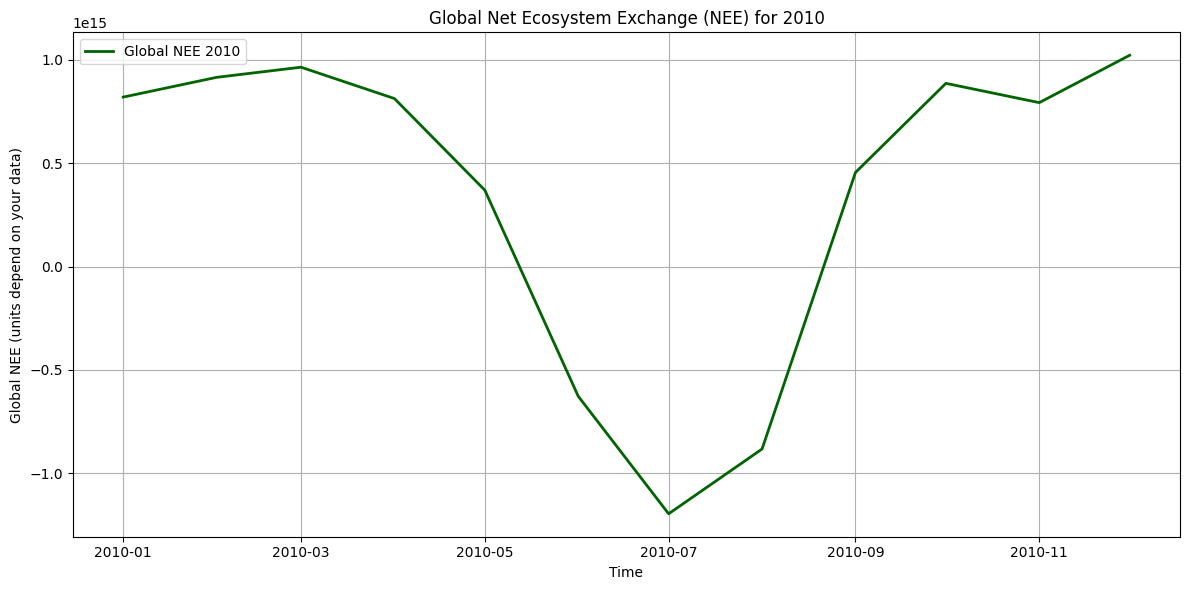

Total global NEE for 2010: 4332684960044165.5000 (units depend on your data)


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Constants
R = 6.371e6  # Earth radius in meters

# Extract lat/lon and compute resolution in radians
lat = dgvm['lat']
lon = dgvm['lon']
dlat = np.deg2rad(lat.diff('lat').mean().item())
dlon = np.deg2rad(lon.diff('lon').mean().item())

# Compute grid cell area per latitude (m²)
lat_rad = np.deg2rad(lat)
area_per_lat = (R**2) * dlat * dlon * np.cos(lat_rad)

# Broadcast area to 2D (lat x lon)
area_2d = area_per_lat.expand_dims(lon=lon).broadcast_like(dgvm['NEE'].isel(time=0))

# Select year to analyze
year_selected = 2010
mask_year = dgvm['time'].dt.year == year_selected

# Subset NEE and time for that year
nee_year = dgvm['NEE'].sel(time=mask_year)
time_year = dgvm['time'].sel(time=mask_year)

# Compute total monthly global NEE by multiplying by area and summing over lat/lon
# (units depend on NEE units, adjust scaling if needed)
global_nee_month = (nee_year * area_2d).sum(dim=['lat', 'lon'])

# Plot monthly global NEE flux for the selected year
plt.figure(figsize=(12,6))
plt.plot(time_year, global_nee_month, label=f'Global NEE {year_selected}', color='darkgreen', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Global NEE (units depend on your data)')
plt.title(f'Global Net Ecosystem Exchange (NEE) for {year_selected}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print yearly total NEE (sum of all months)
total_nee_year = global_nee_month.sum().item()
print(f"Total global NEE for {year_selected}: {total_nee_year:.4f} (units depend on your data)")


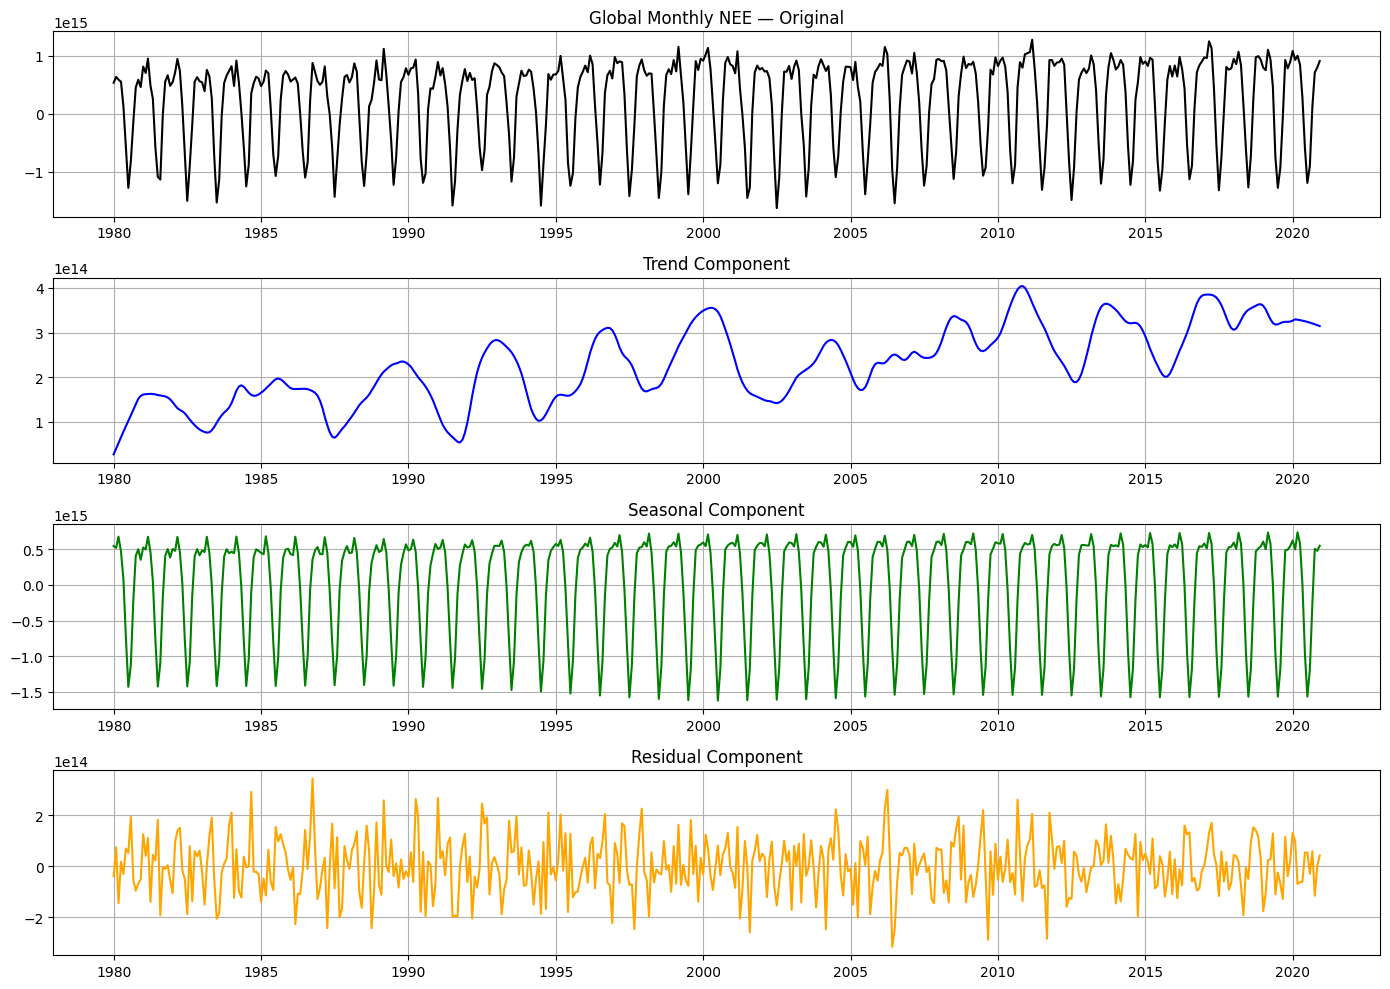

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Assuming you already have:
# dgvm = your xarray dataset loaded
# area_2d = your grid cell areas (lat x lon)
# dgvm['NEE'] = monthly NEE data (time, lat, lon)

# 1. Compute global monthly NEE by weighting with area and summing over lat/lon
global_nee_monthly = (dgvm['NEE'] * area_2d).sum(dim=['lat', 'lon'])

# 2. Extract values and time for STL
nee_values = global_nee_monthly.values  # full monthly NEE time series
time = global_nee_monthly['time'].values  # corresponding time values

# 3. Perform STL decomposition
# Note: period=12 for monthly data (1 year seasonality)
stl_decomposition = STL(nee_values, period=12, seasonal=13)
stl_result = stl_decomposition.fit()

# Extract components
nee_trend = stl_result.trend
nee_seasonal = stl_result.seasonal
nee_residual = stl_result.resid

# 4. Plot results
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(time, nee_values, label='Original NEE', color='black')
plt.title('Global Monthly NEE — Original')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(time, nee_trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(time, nee_seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(time, nee_residual, label='Residual (Noise/Anomalies)', color='orange')
plt.title('Residual Component')
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
pip install regionmask

In [ ]:
# Convert longitudes from [0, 360] to [-180, 180)
dgvm = dgvm.assign_coords(
    lon=(((dgvm.lon + 180) % 360) - 180)
)

# Sort by longitude to ensure consistency
dgvm = dgvm.sortby('lon')


In [ ]:
print(dgvm.lon.min().item(), dgvm.lon.max().item())
print(np.any(np.diff(np.sort(dgvm.lon.values)) == 0))  # Checks for duplicates
print(np.unique((((dgvm.lon + 180) % 360) - 180)).shape[0], dgvm.lon.shape[0])  # Should be equal


-180.0 179.49930458970795
True
719 720


In [ ]:
# Wrap to [-180, 180)
wrapped_lon = (((dgvm.lon + 180) % 360) - 180)

# Drop duplicates if any (due to both -180 and +180 existing)
_, unique_idx = np.unique(wrapped_lon, return_index=True)

# Apply cleaned coordinates
dgvm = dgvm.isel(lon=unique_idx)
dgvm = dgvm.assign_coords(lon=wrapped_lon.isel(lon=unique_idx))
dgvm = dgvm.sortby('lon')


0: Australia
1: Amazon Basin
2: Southern South America
3: Central America
4: Western North America
5: Central North America
6: Eastern North America
7: Alaska
8: Greenland
9: Mediterranean Basin
10: Northern Europe
11: Western Africa
12: Eastern Africa
13: Southern Africa
14: Sahara
15: Southeast Asia
16: East Asia
17: South Asia
18: Central Asia
19: Tibet
20: North Asia


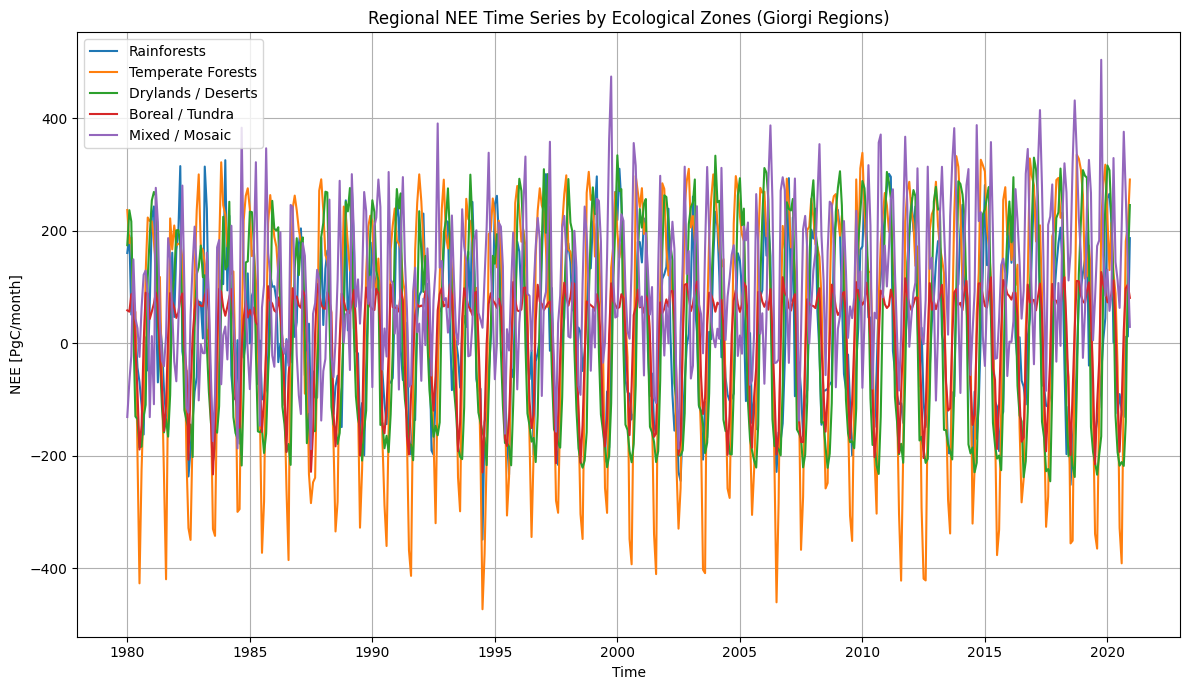

In [ ]:
import regionmask
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Extract coordinates
lat = dgvm['lat']
lon = dgvm['lon']

# Use Giorgi regional mask
giorgi = regionmask.defined_regions.giorgi
mask = giorgi.mask(lon, lat)  # Matches your grid

# Print region index/name mapping
for i, name in enumerate(giorgi.names):
    print(f"{i}: {name}")

ecological_map = {
    "Rainforests": [1, 15, 11],
    "Temperate Forests": [4, 5, 6, 16, 10],
    "Drylands / Deserts": [0, 14, 19],
    "Boreal / Tundra": [7, 8, 20],
    "Mixed / Mosaic": [2, 3, 9, 12, 13, 17, 18]
}

# Apply the mask to the dataset
mask_2d = giorgi.mask(dgvm)

# Use your area_2d from previous step
# Units: NEE is kgC/m²/month — multiply by area to get total kgC/month

regional_timeseries = {}

for group_name, region_indices in ecological_map.items():
    group_mask = mask_2d.isin(region_indices)

    # Mask the NEE data to include only selected regions
    nee_masked = dgvm['NEE'].where(group_mask)

    # Apply area weighting (you already have area_2d ready)
    nee_total = (nee_masked * area_2d).sum(dim=['lat', 'lon'])

    # Convert to PgC/month
    nee_total_pg = nee_total / 1e12

    # Store the time series
    regional_timeseries[group_name] = nee_total_pg

plt.figure(figsize=(12, 7))

for group_name, ts in regional_timeseries.items():
    ts.plot(label=group_name)

plt.legend()
plt.title('Regional NEE Time Series by Ecological Zones (Giorgi Regions)')
plt.ylabel('NEE [PgC/month]')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()


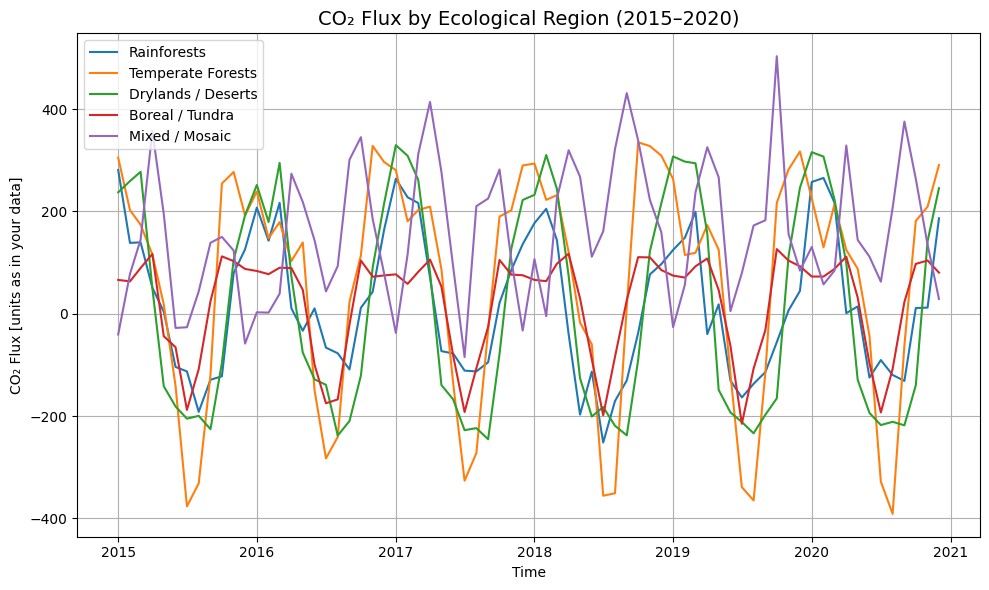

In [ ]:
import matplotlib.pyplot as plt

# Define a 5-year slice (you can change these years)
five_year_slice = slice('2015', '2020')

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot each region's time series in the 5-year window
for group_name, ts in regional_timeseries.items():
    ts.sel(time=five_year_slice).plot(label=group_name)  # Adjust `time` if your time coord is named differently

# Plot formatting
plt.title('CO₂ Flux by Ecological Region (2015–2020)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('CO₂ Flux [units as in your data]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
